In [8]:
import pandas as pd
import os 
from dotenv import load_dotenv, find_dotenv
import openai

In [9]:
_ = load_dotenv(find_dotenv())
openai.api_type = "azure"
openai.api_base = os.getenv('AZURE_OPENAI_ENDPOINT')
openai.api_version = "2023-07-01-preview"
openai.api_key = os.getenv("OPENAI_API_KEY")

In [4]:
# account for deprecation of LLM model
import datetime
# Get the current date
current_date = datetime.datetime.now().date()

# Define the date after which the model should be set to "gpt-3.5-turbo"
target_date = datetime.date(2024, 6, 12)

# Set the model variable based on the current date
if current_date > target_date:
    llm_model = "gpt-3.5-turbo"
else:
    llm_model = "gpt-3.5-turbo-0301"

In [6]:
df = pd.read_csv('Data.csv')
df.head()

,Unnamed: 0,Product,Review
0,0,Queen Size Sheet Set,I ordered a king size set. My only criticism w...
1,1,Waterproof Phone Pouch,"I loved the waterproof sac, although the openi..."
2,2,Luxury Air Mattress,This mattress had a small hole in the top of i...
3,3,Pillows Insert,This is the best throw pillow fillers on Amazo...
4,4,Milk Frother Handheld\n,I loved this product. But they only seem to l...


In [10]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

In [17]:
llm = ChatOpenAI(temperature=0.9, model=llm_model, engine='test')

WARNING! engine is not default parameter.
                    engine was transferred to model_kwargs.
                    Please confirm that engine is what you intended.


In [18]:
prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

In [19]:
chain = LLMChain(llm=llm, prompt=prompt)

In [20]:
product = 'Queen Size Sheet Set'
chain.run(product)

'"RegalRest Linens"'

In [21]:
chain.run('Pillows Insert')

'PillowPerfect'

### Simple Sequential Chains

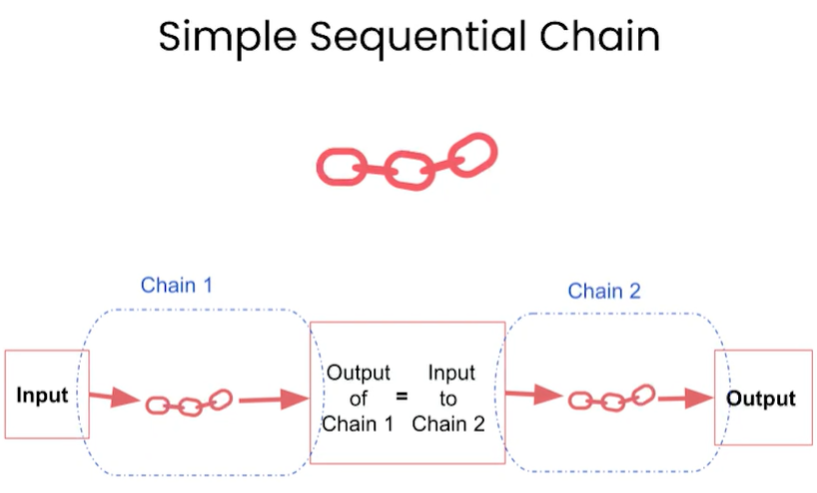

In [23]:
from langchain.chains import SimpleSequentialChain

In [24]:
llm = ChatOpenAI(temperature=0.9, model=llm_model, engine='test')

# Prompt template 1
first_prompt = ChatPromptTemplate.from_template(
  "What is the best name to describe \
    a company that makes {product}?"
) 

# Chain 1
chain_one = LLMChain(llm=llm, prompt=first_prompt)

WARNING! engine is not default parameter.
                    engine was transferred to model_kwargs.
                    Please confirm that engine is what you intended.


In [26]:
# prompt template 2
second_prompt = ChatPromptTemplate.from_template(
    "Write a 20 words description for the following \
    company:{company_name}"
)
# chain 2
chain_two = LLMChain(llm=llm, prompt=second_prompt)

In [27]:
overall_simple_chain = SimpleSequentialChain(chains=[chain_one, chain_two],
                                             verbose=True
                                            )

In [28]:
overall_simple_chain.run(product)



> Entering new SimpleSequentialChain chain...
"Royal Linens"
"Royal Linens offers exquisite bedding and linens fit for royalty, providing luxurious comfort and elegant style for your home."

> Finished chain.


'"Royal Linens offers exquisite bedding and linens fit for royalty, providing luxurious comfort and elegant style for your home."'

### Sequential Chains

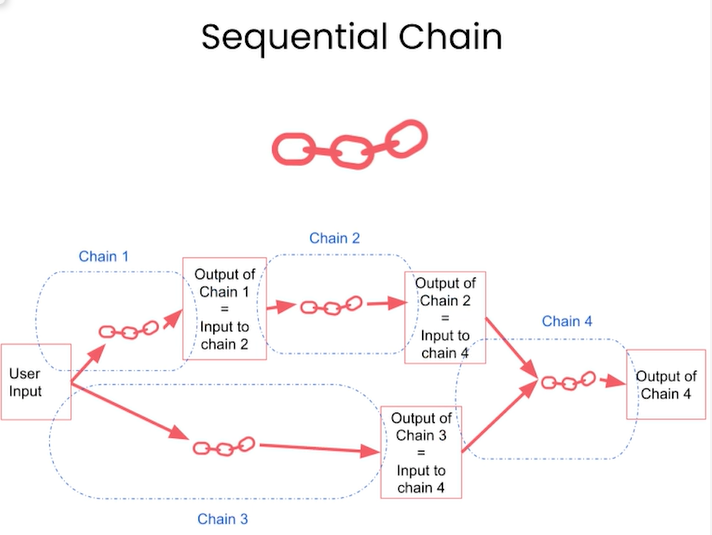

In [29]:
from langchain.chains import SequentialChain

In [30]:
# prompt template 1: translate to english
first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to english:"
    "\n\n{Review}"
)
# chain 1: input= Review and output= English_Review
chain_one = LLMChain(llm=llm, prompt=first_prompt, 
                     output_key="English_Review"
                    )


In [31]:
second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:"
    "\n\n{English_Review}"
)
# chain 2: input= English_Review and output= summary
chain_two = LLMChain(llm=llm, prompt=second_prompt, 
                     output_key="summary"
                    )


In [32]:
# prompt template 3: translate to english
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{Review}"
)
# chain 3: input= Review and output= language
chain_three = LLMChain(llm=llm, prompt=third_prompt,
                       output_key="language"
                      )


In [33]:
# prompt template 4: follow up message
fourth_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following "
    "summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)
# chain 4: input= summary, language and output= followup_message
chain_four = LLMChain(llm=llm, prompt=fourth_prompt,
                      output_key="followup_message"
                     )


In [34]:
# overall_chain: input= Review 
# and output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three, chain_four],
    input_variables=["Review"],
    output_variables=["English_Review", "summary","followup_message"],
    verbose=True
)

In [35]:
review = df.Review[5]
overall_chain(review)



> Entering new SequentialChain chain...

> Finished chain.


{'Review': "Je trouve le goût médiocre. La mousse ne tient pas, c'est bizarre. J'achète les mêmes dans le commerce et le goût est bien meilleur...\nVieux lot ou contrefaçon !?",
 'English_Review': "I find the taste mediocre. The foam doesn't hold, it's strange. I buy the same ones in stores and the taste is much better...\nOld batch or counterfeit!?",
 'summary': 'The reviewer is disappointed with the taste and inconsistency of the foam in the product, suspecting that it might be an old or counterfeit batch.',
 'followup_message': "Réponse de suivi :\n\nCher(e) critique,\n\nNous sommes désolés d'apprendre que vous avez été déçu par le goût et l'inconsistance de la mousse de notre produit. Nous tenons à vous assurer que nous prenons cette question très au sérieux et nous nous engageons à fournir des produits de haute qualité à nos clients.\n\nNous souhaitons clarifier que nous n'utilisons que des ingrédients frais et authentiques dans la fabrication de notre produit. Toutefois, il est p

### Router Chain

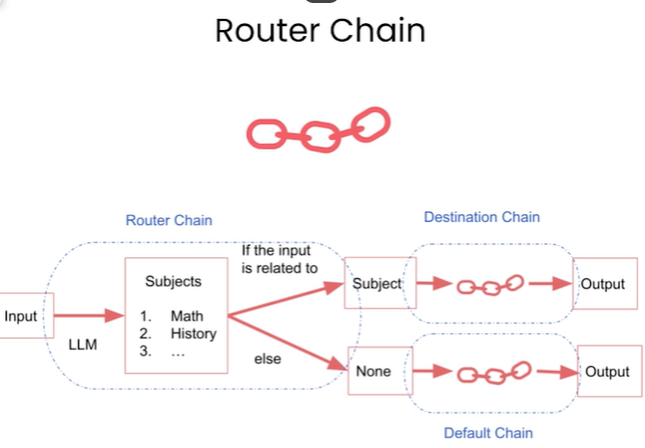

In [36]:
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise\
and easy to understand manner. \
When you don't know the answer to a question you admit\
that you don't know.

Here is a question:
{input}"""


math_template = """You are a very good mathematician. \
You are great at answering math questions. \
You are so good because you are able to break down \
hard problems into their component parts, 
answer the component parts, and then put them together\
to answer the broader question.

Here is a question:
{input}"""

history_template = """You are a very good historian. \
You have an excellent knowledge of and understanding of people,\
events and contexts from a range of historical periods. \
You have the ability to think, reflect, debate, discuss and \
evaluate the past. You have a respect for historical evidence\
and the ability to make use of it to support your explanations \
and judgements.

Here is a question:
{input}"""


computerscience_template = """ You are a successful computer scientist.\
You have a passion for creativity, collaboration,\
forward-thinking, confidence, strong problem-solving capabilities,\
understanding of theories and algorithms, and excellent communication \
skills. You are great at answering coding questions. \
You are so good because you know how to solve a problem by \
describing the solution in imperative steps \
that a machine can easily interpret and you know how to \
choose a solution that has a good balance between \
time complexity and space complexity. 

Here is a question:
{input}"""

In [37]:
prompt_infos = [
    {
        "name": "physics", 
        "description": "Good for answering questions about physics", 
        "prompt_template": physics_template
    },
    {
        "name": "math", 
        "description": "Good for answering math questions", 
        "prompt_template": math_template
    },
    {
        "name": "History", 
        "description": "Good for answering history questions", 
        "prompt_template": history_template
    },
    {
        "name": "computer science", 
        "description": "Good for answering computer science questions", 
        "prompt_template": computerscience_template
    }
]

In [38]:
from langchain.chains.router import MultiPromptChain
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser
from langchain.prompts import PromptTemplate

In [39]:
destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    prompt_template = p_info["prompt_template"]
    prompt = ChatPromptTemplate.from_template(template=prompt_template)
    chain = LLMChain(llm=llm, prompt=prompt)
    destination_chains[name] = chain  
    
destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)

In [40]:
default_prompt = ChatPromptTemplate.from_template("{input}")
default_chain = LLMChain(llm=llm, prompt=default_prompt)

In [41]:
MULTI_PROMPT_ROUTER_TEMPLATE = """Given a raw text input to a \
language model select the model prompt best suited for the input. \
You will be given the names of the available prompts and a \
description of what the prompt is best suited for. \
You may also revise the original input if you think that revising\
it will ultimately lead to a better response from the language model.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ a potentially modified version of the original input
}}}}
```

REMEMBER: "destination" MUST be one of the candidate prompt \
names specified below OR it can be "DEFAULT" if the input is not\
well suited for any of the candidate prompts.
REMEMBER: "next_inputs" can just be the original input \
if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
{destinations}

<< INPUT >>
{{input}}

<< OUTPUT (remember to include the ```json)>>"""

In [42]:
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(
    destinations=destinations_str
)
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(),
)

router_chain = LLMRouterChain.from_llm(llm, router_prompt)

In [43]:
chain = MultiPromptChain(router_chain=router_chain, 
                         destination_chains=destination_chains, 
                         default_chain=default_chain, verbose=True
                        )

In [44]:
chain.run("what is 2 + 2")



> Entering new MultiPromptChain chain...


c:\Users\daffa\anaconda3\envs\langchaindev\lib\site-packages\langchain\chains\llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


math: {'input': 'what is 2 + 2'}
> Finished chain.


"Thank you for your kind words! The question you've asked is a simple addition problem. To find the sum of 2 + 2, we add the two numbers together. \n\nSo, 2 + 2 equals 4."

In [46]:
chain.run("What is black body radiation?")



> Entering new MultiPromptChain chain...


c:\Users\daffa\anaconda3\envs\langchaindev\lib\site-packages\langchain\chains\llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


physics: {'input': 'What is black body radiation?'}
> Finished chain.


"Black body radiation refers to the phenomenon where an object, known as a black body, emits electromagnetic radiation due to its temperature. A black body is an idealized object that absorbs all incoming radiation without reflecting or transmitting any. \n\nAs the temperature of a black body increases, it emits radiation across a wide range of wavelengths, including visible light, infrared, and even some ultraviolet. The distribution of this radiation follows a specific pattern called the black body radiation curve, which depends only on the temperature of the black body.\n\nThis phenomenon was first explained by Max Planck, who proposed that the energy of the emitted radiation is quantized into discrete packets known as photons. Planck's theory of black body radiation laid the foundation for the development of quantum mechanics.\n\nBlack body radiation has many practical applications. For instance, it helps in understanding the behavior of stars and other celestial objects, as well a

In [47]:
chain.run("Why does every cell in our body contain DNA?")



> Entering new MultiPromptChain chain...


c:\Users\daffa\anaconda3\envs\langchaindev\lib\site-packages\langchain\chains\llm.py:321: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


None: {'input': 'Why does every cell in our body contain DNA?'}
> Finished chain.


'Every cell in our body contains DNA because DNA is the genetic material that carries the instructions for the development, functioning, and reproduction of all living organisms. DNA is responsible for determining our physical traits, such as eye color, hair color, and height, as well as our susceptibility to certain diseases. It contains the information required for the synthesis of proteins, which play crucial roles in all cellular processes. In addition, DNA enables cells to pass genetic information from one generation to the next during reproduction, ensuring the continuity of life. Therefore, every cell in our body contains DNA to ensure that the genetic information necessary for maintaining and perpetuating life is present in each individual cell.'